In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import networkx as nx 
from scipy.ndimage import gaussian_filter

from skimage.segmentation import watershed
from skimage.measure import label, regionprops, euler_number
from skimage.future.graph import RAG
from sknetwork.path import distance
from skimage import util
from skimage import filters

from tqdm import tqdm

# import sknetwork as skn
# from scipy import sparse
# from skimage.morphology import disk

In [2]:
#get image and define the image space
image = plt.imread('../images/dna-images/gnf/dna-0.png')[...,0]
image_range = np.array([[i,j]for i in range(image.shape[0]) for j in range(image.shape[1])])

## Algorithm I

In [6]:
def generate_fragments(img,std_dev,int_threshold,min_seed_dist,max_search_depth,max_frag_dist):
    #smooth image with gausian filter
    g = gaussian_filter(img,std_dev)
    #create empty copy of g to fill watersheed markers
    g_markers = np.zeros_like(g)
    #create empty copy of g to check for localmax
    g_checked = np.copy(g)
    
    #Fehlerabfangen
    
    if std_dev < 0:
        raise ValueError("smoothing strength needs to be positive")
    if int_threshold > 1 or int_threshold < 0:
        raise ValueError("relative intensity threshold needs to be between 0 and 1")
    if min_seed_dist < 1:
        raise ValueError("min seed distance needs to be >= 1")
    if max_search_depth < 0:
        raise ValueError("maximum search error needs to be positive")
    if max_frag_dist < 0:
        raise ValueError("maximum fragments distance needs zo be positive")
        
    #Create array of watershed seeds
    PI = []
    #Loop while there are still unchecked regions
    while np.amax(g_checked) != 0:
        #Get indicies of g where g is maximal
        glob_max = np.argwhere(g_checked == g_checked.max())
        #Loop over all maximum points
        for p in glob_max:
            #Set boundaries for the local ball B
            upper_bound = [max(0,p[0]-min_seed_dist),max(0,p[1]-min_seed_dist)]
            lower_bound = [min(p[0]+min_seed_dist+1,g.shape[0]),min(p[1]+min_seed_dist+1,g.shape[1])]
            #Create set with local points around p
            B = g[upper_bound[0]:lower_bound[0],upper_bound[1]:lower_bound[1]]
            #Check if p is strong local maximum
            if (g[tuple(p)] == np.amax(B) and (1-int_threshold)*g[tuple(p)] >= np.amin(B)): 
                #add p to the set of seeds
                PI.append(p)
                #Set label of the seed
                g_markers[tuple(p)] = len(PI)
            #Set the Area B = 0
            g_checked[upper_bound[0]:lower_bound[0],upper_bound[1]:lower_bound[1]] = 0
    
    #Create Watershed regions
    Omega = watershed(util.invert(g),markers=g_markers)

    #create regions
    regions = regionprops(Omega)
    
    #Create edges
    edges = []
    for ra, rb in tqdm(itertools.combinations(regions,2), total = int(0.5 * len(regions) * (len(regions)-1))):
        img_a = Omega == ra.label
        img_b = Omega == rb.label
        img_ab = (img_a + img_b) > 0
        if euler_number(img_ab) == 1 and np.linalg.norm(PI[ra.label -1] - PI[rb.label-1]) <= max_frag_dist:
            edges.append((ra.label-1, rb.label-1))
    G = nx.Graph(edges)
    #nx.draw(G, with_labels = True)

    SG = []

    for r in tqdm(range(2,nx.number_of_nodes(G)+1)):
        for H in (G.subgraph(s) for s in itertools.combinations(G,r)):
            if (nx.is_connected(H)):
                SG.append(H)
    S = []
    #iterate over all graph vertices
    for H in SG:
        for v in nx.nodes(H):
            if max(nx.single_source_shortest_path_length(H, v).values()) <= max_search_depth:
                Nodes = tuple([w for w in nx.nodes(H)])
                #TODO: check if region is simply connected
                S.append(Nodes)
                break
    S = [set(x) for x in S]
    for i in range(len(regions)):
        if regions[i].euler_number == 1:
            S.append({i})
    return Omega,S

###  Test: Algorithm I

100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]


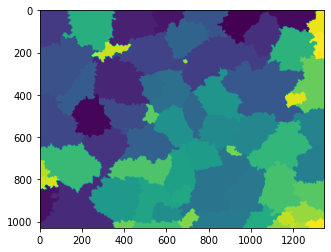

In [12]:
#testing Alg I
Omega,S = generate_fragments(image,1,0.1,50,2,60)
plt.imshow(Omega)

In [10]:
print(S)

[{5, 6}, {59, 54}, {0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, {14}, {15}, {16}, {17}, {18}, {19}, {20}, {21}, {22}, {23}, {24}, {25}, {26}, {27}, {28}, {29}, {30}, {31}, {32}, {33}, {34}, {35}, {36}, {37}, {38}, {39}, {40}, {41}, {42}, {43}, {44}, {45}, {46}, {47}, {48}, {49}, {50}, {51}, {52}, {53}, {54}, {55}, {56}, {57}, {58}, {59}, {60}, {61}, {62}, {63}, {64}, {65}]


### Algorithm II

In [7]:
def global_solution(f,alpha,Omega,S):
    #Set Variables we dont need Z but f_used
    n = len(S) 
    u = np.zeros(n)
    V = Omega
    f_used = np.copy(f)
    #First Loop over copy of Omega
    while V != 0:
        c = np.empty(n)
        #Loop over number of Subgraphs in S
        for k in range(n):
            #Set intersection length
            Zk_V = len(np.intersect1d(Omega,np.array(list(S[k]))))
            #Set c if intersection is non empty 
            if  Zk_V !=0:
                c[k] = (f[k] + alpha) / Zk_V
            #Else set it to nan to ignore it
            else:
                c[k] = np.nan
        #Get the argmin of c
        k_min = np.nanargmin(c)
        #Set u of argmin to 1
        u[k_min] = 1 
        #Loop over all areas in Z_k
        for w in S[k]:
            #Set V of those areas to 0 to indicate that they have been used already
            V[V==w] = 0
    
    #Second loop over not used elements of f
    while f_used != np.empty(n):
        #Set current element of interest k_prim
        k_prim = np.nanargmin(f_used)
        #check if u[_k_prim hasn been used in first loop
        if u[k_prim]==0:
            #crate subvector v of u
            v = np.copy(u)
            #loop over all elements of u that are non zero
            for ind in np.nonzero(u):
                #check if Z_ind is subset of Z_kprim
                if S[ind] not in S[k_prim]:
                    #if not set v to 0 to ignore it in the union
                    v[ind] = 0
            #check if union of all left subsets is equal Z_kprim
            if S[k_prim] == set().union(S[k] for k in np.nonzero(v)):
                #check smth...
                if f[k_prim]+alpha < np.dot(v,f + (alpha*np.ones(n))):
                    #Set u values of the used subsets to 0 and the union to 1
                    u = u-v
                    u[k_prim] = 1
        #make f equal to nan for the used region
        f_used[k_prim]=np.nan
    return u

In [8]:
#Computation of the intensity threshold
def Otsu_thresholding(Z):
    #Set Number of bins 256 for 8-bit
    L = 256
    #Set number of pixel in area Z
    N = Z.size
    #Get the grayvalue histogramm
    hist, _ = np.histogram(Z,bins=L)
    #normalize to get probability distribution
    hist = hist/N
    #function with all variables needed to compute sigma^2_B corresponding to the k-th bin
    def get_sigma(k):
        w = sum(hist[:k+1])
        w_0 = w
        w_1 = 1 - w
        #ignore certain bins according to restricten
        if w_0*w_1 > 0 or 0 < w_0 < 1:
            my = lambda k: sum(i*hist[i] for i in range(k+1))
            my_0 = my(k)/w
            my_1 = (my(L-1)-my(k))/w_1
            sigma_B = w_0*w_1*(my_1-my_0)**2
            return sigma_B
        else:
            return 0
    #compute sigma for all k
    sigma_B_all = np.array([get_sigma(k) for k in range(L)])
    #get the bin with wich maximizes sigma 
    k_max = np.argmax(sigma_B_all)
    #rescale the bin number to the value range of the local area to optain intensity threshold
    tau = k_max*np.max(Z)/(256)
    return tau

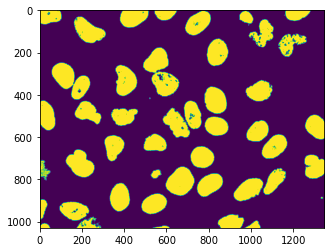

In [106]:
#Test Otsu threshold
#Set label vector
labels = np.unique(Omega)
#Set Vector of local intensity threshold tau coresponding to area with label 
tau = [Otsu_thresholding(image[Omega==label])for label in labels]
#copy image to check threshold
background = np.copy(image)
#loop over all labeled regions and apply threshold
for i in range(len(tau)):
    background[np.multiply(Omega==i+1,background < tau[i])] = 0
    background[np.multiply(Omega==i+1,background >= tau[i])] = 1
plt.imshow(background)
plt.show()

#TODO Compute f --> get alpha as median of f

## Computation of f

we define $y$ as an array consisting of len(Omega) rows, each corresponding to a region. Each row consists of int values corresponding to y_x as defined in paper for $\{x: x \text{ pixel in region}\}$.

In [138]:
y = [image[region.slice] - tau[region.label - 1] for region in regionprops(Omega)]

#define R_k
R = np.copy(S)

for Z in R:
    for region in regionprops(Omega):
        #check if y_x < 0 for every x pixel in region
        if (y[region.label - 1].max()) < 0:
            Z.add(region.label)

In [139]:
print(R)

[{0, 2} {4, 5} {9, 10} {10, 12} {11, 12} {16, 15} {17, 15} {16, 17}
 {17, 18} {17, 19} {18, 19} {18, 20} {20, 21} {20, 22} {21, 22} {22, 23}
 {24, 25} {28, 29} {9, 10, 12} {10, 11, 12} {16, 17, 15} {17, 18, 15}
 {17, 19, 15} {16, 17, 18} {16, 17, 19} {17, 18, 19} {17, 18, 20}
 {18, 19, 20} {18, 20, 21} {18, 20, 22} {20, 21, 22} {20, 22, 23}
 {21, 22, 23} {9, 10, 11, 12} {16, 17, 18, 15} {16, 17, 19, 15}
 {17, 18, 19, 15} {17, 18, 20, 15} {16, 17, 18, 19} {16, 17, 18, 20}
 {17, 18, 19, 20} {17, 18, 20, 21} {17, 18, 20, 22} {18, 19, 20, 21}
 {18, 19, 20, 22} {18, 20, 21, 22} {18, 20, 22, 23} {20, 21, 22, 23}
 {15, 16, 17, 18, 19} {15, 16, 17, 18, 20} {15, 17, 18, 19, 20}
 {15, 17, 18, 20, 21} {15, 17, 18, 20, 22} {16, 17, 18, 19, 20}
 {16, 17, 18, 20, 21} {16, 17, 18, 20, 22} {17, 18, 19, 20, 21}
 {17, 18, 19, 20, 22} {17, 18, 20, 21, 22} {17, 18, 20, 22, 23}
 {18, 19, 20, 21, 22} {18, 19, 20, 22, 23} {18, 20, 21, 22, 23}
 {15, 16, 17, 18, 19, 20} {15, 16, 17, 18, 20, 21}
 {15, 16, 17, 1

## Questions
Do we know how to define A etc. to implement s to be tested?

In [119]:
#need to define s

# define phi
phi = np.log(1+np.exp(-y*s))

TypeError: bad operand type for unary -: 'function'